# Installation and Imports

In [3]:
pip install keras_tuner


  Using cached keras_tuner-1.4.7-py3-none-any.whl.metadata (5.4 kB)
  Using cached kt_legacy-1.0.5-py3-none-any.whl.metadata (221 bytes)
Using cached keras_tuner-1.4.7-py3-none-any.whl (129 kB)
Using cached kt_legacy-1.0.5-py3-none-any.whl (9.6 kB)


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras_tuner as kt
import os

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [3]:
image_size = 48
folder_path = "C:/Users/Victor/Desktop/OPA saker/ai2_del2_modell/images/"

train_image_count=28821
val_image_count=7066
batch_size = 128

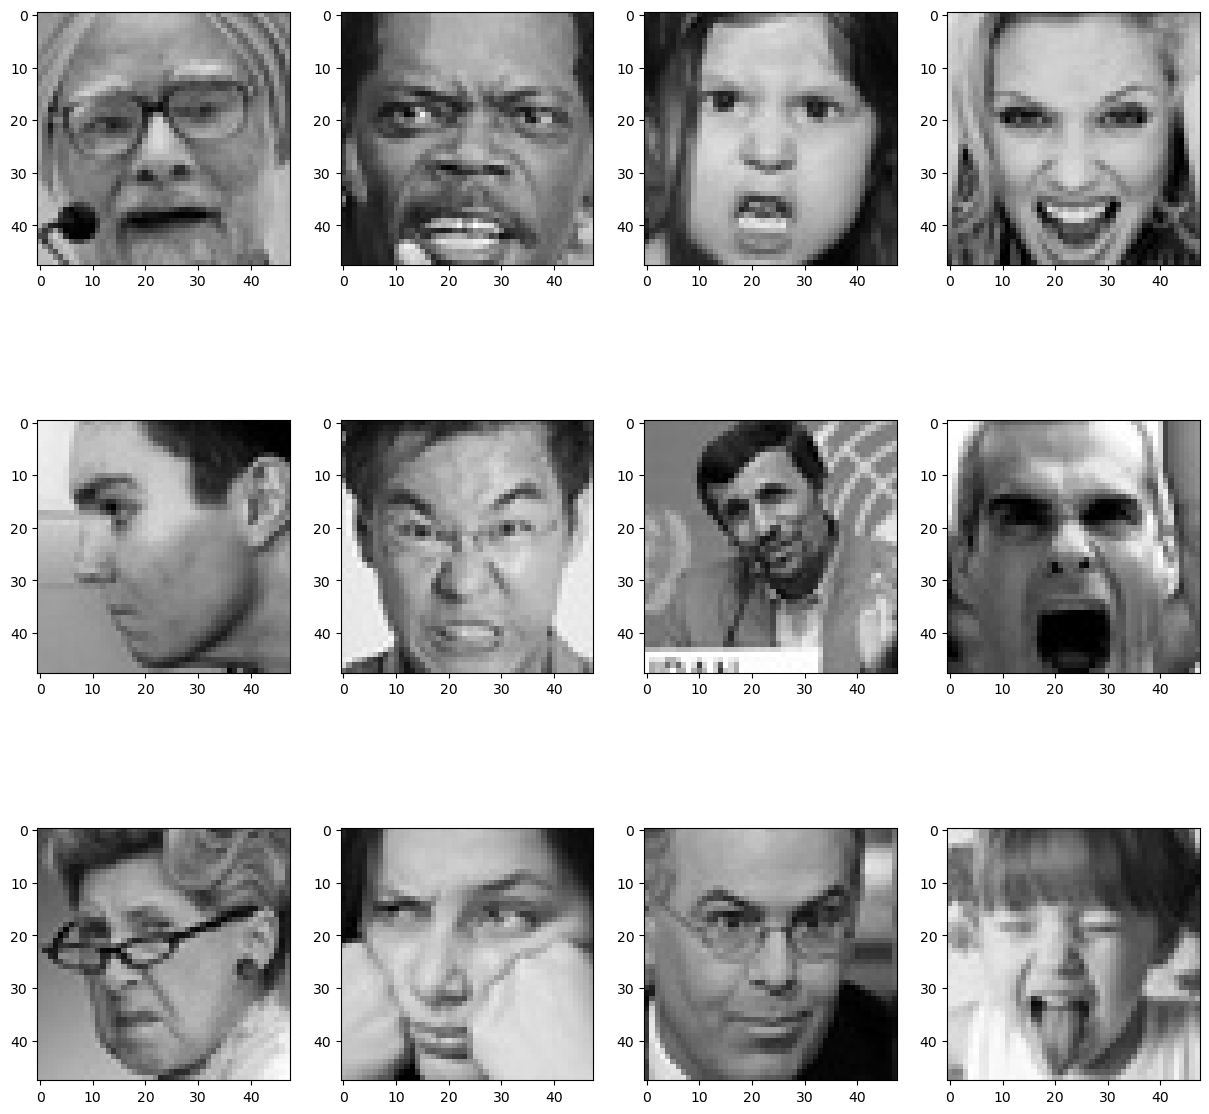

In [4]:
expression_target = 'angry'

plt.figure(figsize = (15,15))
for i in range(1,13,1):
    plt.subplot(3,4,i)
    img = load_img(folder_path + "train/" + expression_target + "/" + 
                   os.listdir(folder_path + "train/" + expression_target)[i], target_size=(image_size,image_size))
    plt.imshow(img)
plt.show()

# Creating Datasets

In [5]:

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


training_set = train_datagen.flow_from_directory(folder_path + "train", 
                                                 target_size=(image_size,image_size),
                                                 color_mode="grayscale",
                                                 batch_size= batch_size,
                                                 class_mode="categorical",
                                                 shuffle=True)


validation_set = val_datagen.flow_from_directory(folder_path + "validation", 
                                                 target_size=(image_size,image_size),
                                                 color_mode="grayscale",
                                                 batch_size= batch_size,
                                                 class_mode="categorical",
                                                 shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Experimental Data Pipline

In [3]:
print(str(folder_path + 'train'))

C:/Users/Victor/Desktop/OPA saker/ai2_del2_modell/images/train


In [136]:
list_train_data = tf.data.Dataset.list_files(str(folder_path+'train/*/*'), shuffle=False)
list_train_data = list_train_data.shuffle(train_image_count, reshuffle_each_iteration=False)

list_val_data = tf.data.Dataset.list_files(str(folder_path+'validation/*/*'), shuffle=False)
list_val_data = list_val_data.shuffle(val_image_count, reshuffle_each_iteration=False)

class_labels = ['angry','disgust','fear','happy','neutral','sad','surprise']
epochs = 50

In [137]:
training_set = list_train_data

validation_set = list_val_data

print(tf.data.experimental.cardinality(training_set).numpy())
print(tf.data.experimental.cardinality(validation_set).numpy())


28821
7066


In [32]:
training_set

<ShuffleDataset shapes: (), types: tf.string>

In [138]:
def get_label(file_path):
    path_comp = tf.strings.split(file_path, os.path.sep)
    one_hot = path_comp[-2] == class_labels
    one_hot = tf.one_hot(one_hot, len(class_labels))
    return one_hot

def decode_image(image):
    image = tf.io.decode_jpeg(image, channels=1)
    return tf.image.resize(image, [image_size,image_size])

def process_path(file_path):
    label = get_label(file_path)
    image = tf.io.read_file(file_path)
    image = decode_image(image)
    return image, label

In [139]:
training_set = training_set.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_set = validation_set.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

for image, label in training_set.take(1):
    print('Image shape: ', image.numpy().shape)
    print('Label: ', label.numpy())

TypeError: in user code:

    C:\Users\Victor\AppData\Local\Temp\ipykernel_17612\879028880.py:12 process_path  *
        label = get_label(file_path)
    C:\Users\Victor\AppData\Local\Temp\ipykernel_17612\3405593623.py:4 get_label  *
        one_hot = tf.one_hot(one_hot, len(class_labels))
    c:\Users\Victor\anaconda3\envs\ai_1\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    c:\Users\Victor\anaconda3\envs\ai_1\lib\site-packages\tensorflow\python\ops\array_ops.py:4123 one_hot
        name)
    c:\Users\Victor\anaconda3\envs\ai_1\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:6326 one_hot
        off_value=off_value, axis=axis, name=name)
    c:\Users\Victor\anaconda3\envs\ai_1\lib\site-packages\tensorflow\python\framework\op_def_library.py:578 _apply_op_helper
        param_name=input_name)
    c:\Users\Victor\anaconda3\envs\ai_1\lib\site-packages\tensorflow\python\framework\op_def_library.py:61 _SatisfiesTypeConstraint
        ", ".join(dtypes.as_dtype(x).name for x in allowed_list)))

    TypeError: Value passed to parameter 'indices' has DataType bool not in list of allowed values: uint8, int32, int64


In [114]:
def configure_for_perfromance(ds):
    ds = ds.cache()
    ds = ds.shuffle(ds.cardinality())
    ds = ds.batch(batch_size)
    ds = ds.repeat(epochs)
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    return ds

In [108]:
def encode_lables(ds):
    for (image,label) in ds:
        ds = to_categorical(label, len(class_labels))
        print(label.numpy())
        return ds

In [10]:
training_set = training_set.cache()
training_set = training_set.shuffle(training_set.cardinality())
training_set = training_set.batch(batch_size)
training_set = training_set.repeat(epochs)
training_set = training_set.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [11]:
validation_set = validation_set.cache()
validation_set = validation_set.shuffle(training_set.cardinality())
validation_set = validation_set.batch(batch_size)
validation_set = validation_set.repeat(epochs)
validation_set = validation_set.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [115]:
training_set = configure_for_perfromance(training_set)
validation_set = configure_for_perfromance(validation_set)

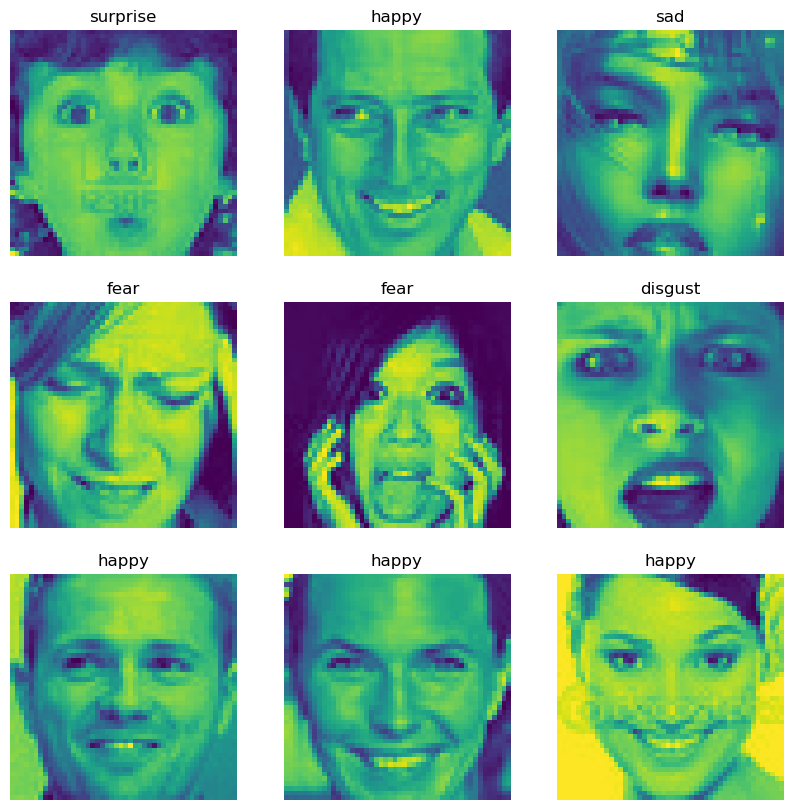

In [12]:
image_batch, label_batch = next(iter(training_set))

plt.figure(figsize=(10, 10))
for j in range(9):
  ax = plt.subplot(3, 3, j + 1)
  plt.imshow(image_batch[j].numpy().astype("uint8"))
  label = label_batch[j]
  plt.title(class_labels[label])
  plt.axis("off")

In [125]:
for (image, label) in training_set:
    label = to_categorical(label,7)
    print(image.numpy().shape,label)
    break

(128, 48, 48, 1) [[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 ...

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0.

In [124]:
validation_set
for (image, label) in validation_set:
    print(image.numpy().shape,label.numpy())
    break

(128, 48, 48, 1) [[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]

In [93]:

for (image, label) in training_set:
    print(image.numpy().shape,label.numpy())
    break

ValueError: too many values to unpack (expected 2)

# Model Creation and Tuning

In [12]:
def build_model(hp):
    classes = 7

    model = Sequential()

    # First Conv layer
    model.add(Conv2D(64,(3,3), padding="same", input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))

    # Second Conv layer
    model.add(Conv2D(
        hp.Choice('units',[64,96,128]),
        (3,3), 
        padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))

    # Third Conv layer
    model.add(Conv2D(
        hp.Choice('units',[128,192,256]),
        (3,3), 
        padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))

    # Fourth Conv layer
    model.add(Conv2D(
        hp.Choice('units',[256,96,512]),
        (3,3), 
        padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))

    # Flatten pass
    model.add(Flatten())

    # First Dense layer
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.25))

    # Second Dense layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.25))

    # Output Dense layer
    model.add(Dense(classes, activation="softmax"))

    # Model compilation and summary
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=['accuracy'])
    model.summary()
    return model

In [13]:
tuner = kt.RandomSearch(build_model,objective='val_accuracy',max_trials=5)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,02

 Total params: 398,407 (1.52 MB)

 Trainable params: 396,359 (1.51 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [14]:
epochs= 20

# Checkpoints model upon training degredation
checkpoint = ModelCheckpoint(filepath='C:/Users/Victor/Desktop/OPA saker/ai2_del2_modell/model/model.keras',
                             monitor="val_accuracy", 
                             verbose=1, 
                             save_best_only=True, 
                             mode="max")

# Stops the learning upon training degredation and restores previous 
# training weights
early_stopping = EarlyStopping(monitor="val_loss",
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)

# Reduces learning rate upon training plateau
reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.2,
                              patience=2,
                              verbose=1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_lr]

In [15]:
tuner.search(training_set, epochs=epochs, validation_data=validation_set, callbacks=callbacks_list)

Trial 3 Complete [00h 24m 52s]
val_accuracy: 0.3983866274356842

Best val_accuracy So Far: 0.49264082312583923
Total elapsed time: 01h 24m 56s


# Model Training

In [18]:
validation_epochs= 40

model = tuner.get_best_models()[0]

c:\Users\Victor\anaconda3\envs\ai2\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 804,871 (3.07 MB)

 Trainable params: 802,439 (3.06 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/40


c:\Users\Victor\anaconda3\envs\ai2\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.4651 - loss: 1.3851
Epoch 1: val_accuracy improved from -inf to 0.48622, saving model to C:/Users/Victor/Desktop/OPA saker/ai2_del2_modell/model/model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 98s 420ms/step - accuracy: 0.4651 - loss: 1.3851 - val_accuracy: 0.4862 - val_loss: 1.3257 - learning_rate: 1.0000e-04
Epoch 2/40
  1/225 ━━━━━━━━━━━━━━━━━━━━ 1:11 317ms/step - accuracy: 0.4375 - loss: 1.4574
Epoch 2: val_accuracy improved from 0.48622 to 0.57692, saving model to C:/Users/Victor/Desktop/OPA saker/ai2_del2_modell/model/model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.4375 - loss: 1.4574 - val_accuracy: 0.5769 - val_loss: 1.3859 - learning_rate: 1.0000e-04
Epoch 3/40


c:\Users\Victor\anaconda3\envs\ai2\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.4759 - loss: 1.3600
Epoch 3: val_accuracy did not improve from 0.57692

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
225/225 ━━━━━━━━━━━━━━━━━━━━ 95s 418ms/step - accuracy: 0.4759 - loss: 1.3600 - val_accuracy: 0.4790 - val_loss: 1.3350 - learning_rate: 1.0000e-04
Epoch 4/40
  1/225 ━━━━━━━━━━━━━━━━━━━━ 1:11 318ms/step - accuracy: 0.4531 - loss: 1.3787
Epoch 4: val_accuracy did not improve from 0.57692
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 120us/step - accuracy: 0.4531 - loss: 1.3787 - val_accuracy: 0.5769 - val_loss: 1.3388 - learning_rate: 2.0000e-05
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [20]:
history = model.fit(training_set,
                    steps_per_epoch=(training_set.n//training_set.batch_size),
                    epochs=validation_epochs,
                    validation_data=validation_set,
                    validation_steps=(validation_set.n//validation_set.batch_size),
                    callbacks=callbacks_list)

Epoch 1/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.4793 - loss: 1.3562
Epoch 1: val_accuracy did not improve from 0.65385
225/225 ━━━━━━━━━━━━━━━━━━━━ 96s 425ms/step - accuracy: 0.4793 - loss: 1.3562 - val_accuracy: 0.4966 - val_loss: 1.2870 - learning_rate: 4.0000e-06
Epoch 2/40
  1/225 ━━━━━━━━━━━━━━━━━━━━ 1:10 314ms/step - accuracy: 0.4922 - loss: 1.3341
Epoch 2: val_accuracy did not improve from 0.65385
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.4922 - loss: 1.3341 - val_accuracy: 0.6538 - val_loss: 1.1400 - learning_rate: 4.0000e-06
Epoch 3/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.4789 - loss: 1.3538
Epoch 3: val_accuracy did not improve from 0.65385
225/225 ━━━━━━━━━━━━━━━━━━━━ 94s 416ms/step - accuracy: 0.4789 - loss: 1.3538 - val_accuracy: 0.4963 - val_loss: 1.2880 - learning_rate: 4.0000e-06
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
